In [18]:
import numpy as np
import pandas as pd
import seaborn as sns

import anndata as ad
import spatialdata as sd
import spatialdata_plot
from spatialdata import SpatialData
from spatialdata_io import xenium
from spatialdata import polygon_query

import scanpy as sc
import squidpy as sq
import cellcharter as cc
import scvi

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib_venn import venn3
from matplotlib.colors import ListedColormap

from lightning.pytorch import seed_everything

import os

import mygene

import copy

import warnings

from pathlib import Path

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from scipy.stats import gaussian_kde 
from scipy.signal import find_peaks
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, adjusted_rand_score

In [19]:
varrone_df = pd.read_csv('/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_cell_types.csv')

In [20]:
adata_big = sc.read_h5ad("/mnt/ptemp/virginia/project/breast_cancer_atlas_cellxgene_epithelial.h5ad")

In [21]:
adata_small = sc.read('/mnt/ptemp/virginia/project/cbbb607f-578b-47ba-858b-407bb8be917f.h5ad')

In [22]:
xenium = sd.read_zarr("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC.zarr")

/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [23]:
adata_small.X = adata_small.raw.X 
adata_small.X.data

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [24]:
#1. Filtro adata_small e mantengo solo le cellule epiteliali
adata_small_epit = adata_small[
    (adata_small.obs['celltype_major'].isin(['Normal Epithelial', 'Cancer Epithelial']))].copy()

In [25]:
#2. Modifico i nomi in adata_small_epit ovvero Cancer Epithelial in Malignant_epithelial e Normal Epithelial in Normal_epithelial 
adata_small_epit.obs["celltype_major"] = adata_small_epit.obs["celltype_major"].replace(
    {"Cancer Epithelial": "Malignant_epithelial", "Normal Epithelial": "Normal_epithelial"})

/tmp/ipykernel_2203727/2570862550.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata_small_epit.obs["celltype_major"] = adata_small_epit.obs["celltype_major"].replace(


In [26]:
# Recupero gli Ensembl IDs da data.table.var['gene_ids']
xenium_gene_ids = xenium.table.var['gene_ids'].tolist()  

# Recupero gli Ensembl IDs da adata_new.var_names
adata_gene_ids = adata_big.var['feature_id'].tolist()  

# Confronto gli ID dei geni
only_in_xenium = set(xenium_gene_ids) - set(adata_gene_ids)
only_in_adata = set(adata_gene_ids) - set(xenium_gene_ids)

print(f"Genes only in xenium: {len(only_in_xenium)}")  
print(f"Genes only in adata_big: {len(only_in_adata)}")

# Filtro adata_big per mantenere solo i geni che sono in 'xenium'
adata_big_filtered = adata_big[:, adata_big.var['feature_id'].isin(xenium_gene_ids)]
print(f"After filtering, the shape of adata_big_filtered is: {adata_big_filtered.shape}")  

Genes only in xenium: 0
Genes only in adata_big: 61608
After filtering, the shape of adata_big_filtered is: (1101803, 280)


/tmp/ipykernel_2203727/2572632232.py:2: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  xenium_gene_ids = xenium.table.var['gene_ids'].tolist()


In [27]:
adata_big_filtered.layers["counts"] = adata_big_filtered.X.copy()
adata_big_filtered.var = adata_big_filtered.var[['feature_id'] + [col for col in adata_big_filtered.var.columns if col != 'feature_id']]
adata_big_filtered.var.set_index("feature_id", inplace=True)

/tmp/ipykernel_2203727/2983062528.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_big_filtered.layers["counts"] = adata_big_filtered.X.copy()


In [28]:
#3. Creo un terzo anndata unendo adata_small e adata_big e lo faccio in base ai nomi Normal_epithelial e Malignant_epithelial
adata_combined = ad.concat([adata_small_epit, adata_big_filtered], join="outer")

/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/anndata/_core/merge.py:1410: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [29]:
adata_xenium = xenium.tables['table']

In [30]:
adata_xenium_cell_ids = set(adata_xenium.obs['cell_id'])

In [31]:
filtered_varrone_df = varrone_df[varrone_df['cell_id'].isin(adata_xenium_cell_ids)]

In [32]:
# Aggiungo la colonna 'level1' da varrone_df a adata_original.obs in base al 'cell_id'
adata_xenium.obs['level1'] = adata_xenium.obs['cell_id'].map(filtered_varrone_df.set_index('cell_id')['level1'])
adata_xenium.obs['level2'] = adata_xenium.obs['cell_id'].map(filtered_varrone_df.set_index('cell_id')['level2'])

adata_xenium.obs['level2'] = adata_xenium.obs['level2'].replace({
    'Malignant_epithelial': 'Malignant',
    'Normal_epithelial': 'Normal'})

In [33]:
# Filtro l'AnnData per includere solo le cellule con 'Epithelial' in 'level1'
epithelial_cells = adata_xenium[adata_xenium.obs['level1'] == 'Epithelial']

num_epithelial_cells = epithelial_cells.shape[0]
print(f"Number of epithelial cells: {num_epithelial_cells}")  

Number of epithelial cells: 350729


In [99]:
# QUALITY FILTERING




# Filtro l'AnnData per includere solo le cellule con 'Epithelial' in 'level1'
epithelial_cells = adata_xenium[adata_xenium.obs['level1'] == 'Epithelial']

# Filtro per total_counts >= 10
epithelial_cells = epithelial_cells[epithelial_cells.obs['total_counts'] >= 10]

# Verifica il numero di cellule rimanenti
num_epithelial_cells = epithelial_cells.shape[0]
print(f"Number of epithelial cells after filtering: {num_epithelial_cells}")


Number of epithelial cells after filtering: 348982


In [129]:
# QUALITY FILTERING + DATI MOLECOLARI SCALATI





import scanpy as sc
import numpy as np

# 1️⃣ Filtra solo cellule epiteliali
epithelial_cells = adata_xenium[adata_xenium.obs['level1'] == 'Epithelial'].copy()
print(f"Numero di cellule epiteliali iniziali: {epithelial_cells.shape[0]}")

# 2️⃣ Calcola total_counts e filtra cellule artefatto
epithelial_cells.obs['total_counts'] = np.array(epithelial_cells.X.sum(axis=1)).flatten()
epithelial_cells = epithelial_cells[epithelial_cells.obs['total_counts'] >= 10].copy()
print(f"Numero di cellule dopo filtro total_counts >=10: {epithelial_cells.shape[0]}")

# 4️⃣ Applica scaling sui dati molecolari
sc.pp.scale(epithelial_cells, zero_center=True, max_value=10)

# 5️⃣ Downsampling bilanciato (25k maligne + 25k normali)
malignant = epithelial_cells[epithelial_cells.obs['level2'] == 'Malignant']
normal = epithelial_cells[epithelial_cells.obs['level2'] == 'Normal']

# Controlla se ci sono abbastanza cellule
n_sample = min(25000, malignant.shape[0], normal.shape[0])

np.random.seed(42)  # per riproducibilità
malignant_down = malignant[np.random.choice(malignant.shape[0], n_sample, replace=False)].copy()
normal_down = normal[np.random.choice(normal.shape[0], n_sample, replace=False)].copy()

# Unisci di nuovo
epithelial_cells_balanced = malignant_down.concatenate(normal_down, batch_key=None)
print(f"Numero totale di cellule nel dataset bilanciato: {epithelial_cells_balanced.shape[0]}")

# 6️⃣ Salva il nuovo AnnData pronto per le analisi
epithelial_cells_balanced.write("epithelial_cells_filtered_scaled_balanced.h5ad")



Numero di cellule epiteliali iniziali: 350729
Numero di cellule dopo filtro total_counts >=10: 348980


/tmp/ipykernel_2203727/608511348.py:34: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  epithelial_cells_balanced = malignant_down.concatenate(normal_down, batch_key=None)


Numero totale di cellule nel dataset bilanciato: 50000


In [134]:
epithelial_cells.obs

,cell_id,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area,region,sample,level1,level2
7,8,167,0,0,167.0,127.566406,49.717031,cell_circles,Xenium_V1_FFPE_Human_Breast_IDC,Epithelial,Malignant
9,10,197,0,0,197.0,240.366719,23.842500,cell_circles,Xenium_V1_FFPE_Human_Breast_IDC,Epithelial,Malignant
16,17,68,0,0,68.0,48.859063,28.990313,cell_circles,Xenium_V1_FFPE_Human_Breast_IDC,Epithelial,Malignant
17,18,21,0,0,21.0,12.192188,5.599375,cell_circles,Xenium_V1_FFPE_Human_Breast_IDC,Epithelial,Normal
18,19,38,0,0,38.0,34.725156,13.908125,cell_circles,Xenium_V1_FFPE_Human_Breast_IDC,Epithelial,Malignant
...,...,...,...,...,...,...,...,...,...,...,...
574823,574824,155,0,0,155.0,196.249063,49.897656,cell_circles,Xenium_V1_FFPE_Human_Breast_IDC,Epithelial,Malignant
574832,574833,201,0,0,201.0,206.409219,69.901875,cell_circles,Xenium_V1_FFPE_Human_Breast_IDC,Epithelial,Malignant
574835,574836,64,0,0,64.0,78.933125,40.369688,cell_circles,Xenium_V1_FFPE_Human_Breast_IDC,Epithelial,Malignant
574836,574837,112,0,0,112.0,188.120937,27.635625,cell_circles,Xenium_V1_FFPE_Human_Breast_IDC,Epithelial,Malignant


In [100]:
# Salvo 'epithelial_cells'
epithelial_cells.write("epithelial_cells_level2.h5ad")

/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: T

In [104]:
# PER VALUTARE QUALE DATASET USARE e PER CREARE IL FILE CON epithelial_cells CHE CONTIENE 'cell_type_prediction'
epithelial_cells.var_names = epithelial_cells.var['gene_ids']

In [105]:
sc.pp.normalize_total(epithelial_cells, inplace=True)
sc.pp.log1p(epithelial_cells) 

In [38]:
# DATASET: IDC TUMOR + IDC NORMAL 

# Filtro combinato per includere: 
# - IDC (ductal) con 'malignant' e 'normal'

adata_filtered_IDC = adata_combined[
    (
        (adata_combined.obs['disease'] == 'invasive ductal breast carcinoma') &
        (adata_combined.obs['celltype_major'].isin(['Malignant_epithelial', 'Normal_epithelial']))
    ) 
].copy()

adata_filtered_IDC

AnnData object with n_obs × n_vars = 22196 × 29069
    obs: 'donor_id', 'percent_mito', 'nCount_RNA', 'nFeature_RNA', 'celltype_major', 'celltype_minor', 'celltype_subset', 'subtype', 'gene_module', 'calls', 'normal_cell_call', 'CNA_value', 'batch_run', 'multiplexed', 'cryo_state', 'development_stage_ontology_term_id', 'cancer_type', 'ER', 'PR', 'HER2_IHC', 'HER2_ISH', 'HER2_ISH_ratio', 'Ki67', 'subtype_by_IHC', 'treatment_status', 'treatment_details', 'assay_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'disease_ontology_term_id', 'grade', 'cell_type_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'dataset'
    obsm: 'X_Three-D', 'X_umap'
    layers: 'counts'

In [40]:
# Conta delle cellule epiteliali maligne
n_malignant = adata_filtered_IDC.obs[adata_filtered_IDC.obs['celltype_major'] == 'Malignant_epithelial'].shape[0]

# Conta delle cellule epiteliali normali
n_normal = adata_filtered_IDC.obs[adata_filtered_IDC.obs['celltype_major'] == 'Normal_epithelial'].shape[0]

print(f"Malignant epithelial cells: {n_malignant}")
print(f"Normal epithelial cells: {n_normal}")


Malignant epithelial cells: 19829
Normal epithelial cells: 2367


In [106]:
# DATASET SCELTO: IDC TUMOR + IDC NORMAL + ILC NORMAL !!!!!!

# Filtro combinato per includere:
# - IDC (ductal) con 'malignant' e 'normal'
# - ILC (lobular) solo con 'normal'

adata_filtered_IDC_normal_ILC = adata_combined[
    (
        (adata_combined.obs['disease'] == 'invasive ductal breast carcinoma') &
        (adata_combined.obs['celltype_major'].isin(['Malignant_epithelial', 'Normal_epithelial']))
    ) |
    (
        (adata_combined.obs['disease'] == 'invasive lobular breast carcinoma') &
        (adata_combined.obs['celltype_major'] == 'Normal_epithelial')
    )
].copy()

adata_filtered_IDC_normal_ILC

AnnData object with n_obs × n_vars = 24184 × 29069
    obs: 'donor_id', 'percent_mito', 'nCount_RNA', 'nFeature_RNA', 'celltype_major', 'celltype_minor', 'celltype_subset', 'subtype', 'gene_module', 'calls', 'normal_cell_call', 'CNA_value', 'batch_run', 'multiplexed', 'cryo_state', 'development_stage_ontology_term_id', 'cancer_type', 'ER', 'PR', 'HER2_IHC', 'HER2_ISH', 'HER2_ISH_ratio', 'Ki67', 'subtype_by_IHC', 'treatment_status', 'treatment_details', 'assay_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'disease_ontology_term_id', 'grade', 'cell_type_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'dataset'
    obsm: 'X_Three-D', 'X_umap'
    layers: 'counts'

In [107]:
# Conta delle cellule epiteliali maligne
n_malignant = adata_filtered_IDC_normal_ILC.obs[adata_filtered_IDC_normal_ILC.obs['celltype_major'] == 'Malignant_epithelial'].shape[0]

# Conta delle cellule epiteliali normali
n_normal = adata_filtered_IDC_normal_ILC.obs[adata_filtered_IDC_normal_ILC.obs['celltype_major'] == 'Normal_epithelial'].shape[0]

print(f"Malignant epithelial cells: {n_malignant}")
print(f"Normal epithelial cells: {n_normal}")

Malignant epithelial cells: 19829
Normal epithelial cells: 4355


In [43]:
import mygene
import pandas as pd

mg = mygene.MyGeneInfo()

# Estrai i nomi dei geni (Ensembl) dal tuo AnnData
ensembl_ids = adata_filtered_IDC_normal_ILC.var_names.tolist()

# Richiedi i simboli genici corrispondenti
query = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')

# Se la colonna 'notfound' non esiste, viene creata con valore False
mapping_df['notfound'] = mapping_df.get('notfound', False).fillna(False)

# Filtra le righe trovate correttamente
mapping_df = mapping_df[~mapping_df['notfound']]

# Filtra anche quelle senza simbolo genico
mapping_df = mapping_df.dropna(subset=['symbol'])


# Crea un dizionario Ensembl → Symbol
id_to_symbol = dict(zip(mapping_df['query'], mapping_df['symbol']))


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
18 input query terms found dup hits:	[('ENSG00000188660', 2), ('ENSG00000226506', 2), ('ENSG00000226519', 2), ('ENSG00000227110', 2), ('E
602 input query terms found no hit:	['ENSG00000131484', 'ENSG00000132832', 'ENSG00000139656', 'ENSG00000146521', 'ENSG00000168078', 'ENS


NameError: name 'mapping_df' is not defined

In [44]:
# Recupera la colonna gene_symbol
gene_symbols = adata_filtered_IDC_normal_ILC.var['gene_symbol']

# Fallback: crea una Series con Ensembl ID
fallback = pd.Series(adata_filtered_IDC_normal_ILC.var_names, index=adata_filtered_IDC_normal_ILC.var.index)

# Rimpiazza i NaN con gli Ensembl ID originali
filled_symbols = gene_symbols.fillna(fallback)

# Forza tutto a stringa (evita float tipo NaN)
adata_filtered_IDC_normal_ILC.var['gene_symbol'] = filled_symbols.astype(str)

# Assegna e rendi univoci i var_names
adata_filtered_IDC_normal_ILC.var_names = adata_filtered_IDC_normal_ILC.var['gene_symbol']
adata_filtered_IDC_normal_ILC.var_names_make_unique()


KeyError: 'gene_symbol'

In [45]:
# DATASET: IDC TUMOR + IDC NORMAL + ILC NORMAL + ILC TUMOR

# Filtro combinato per includere:
# - IDC (ductal) con 'malignant' e 'normal'
# - ILC (lobular) con 'malignant' e 'normal'

adata_filtered_IDC_ILC = adata_combined[
    (
        (adata_combined.obs['disease'] == 'invasive ductal breast carcinoma') &
        (adata_combined.obs['celltype_major'].isin(['Malignant_epithelial', 'Normal_epithelial']))
    ) |
    (
        (adata_combined.obs['disease'] == 'invasive lobular breast carcinoma') &
        (adata_combined.obs['celltype_major'].isin(['Malignant_epithelial', 'Normal_epithelial']))
    )
].copy()

adata_filtered_IDC_ILC

AnnData object with n_obs × n_vars = 26619 × 29069
    obs: 'donor_id', 'percent_mito', 'nCount_RNA', 'nFeature_RNA', 'celltype_major', 'celltype_minor', 'celltype_subset', 'subtype', 'gene_module', 'calls', 'normal_cell_call', 'CNA_value', 'batch_run', 'multiplexed', 'cryo_state', 'development_stage_ontology_term_id', 'cancer_type', 'ER', 'PR', 'HER2_IHC', 'HER2_ISH', 'HER2_ISH_ratio', 'Ki67', 'subtype_by_IHC', 'treatment_status', 'treatment_details', 'assay_ontology_term_id', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'disease_ontology_term_id', 'grade', 'cell_type_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'dataset'
    obsm: 'X_Three-D', 'X_umap'
    layers: 'counts'

In [130]:
# Parametri modificabili

a = adata_filtered_IDC_normal_ILC
#a = adata_filtered_IDC
#a = adata_filtered_IDC_ILC

b = 'IDC_and_Normal_ILC'
#b = 'IDC'
#b = 'IDC_ILC'

group = "celltype_major"
variable = "logfoldchanges"
n_genes = 50

os.makedirs("figures", exist_ok=True)
os.makedirs("figures/dotplot", exist_ok=True)
os.makedirs("figures/umap", exist_ok=True)

os.makedirs("results", exist_ok=True)

In [131]:
sc.pp.normalize_total(a, inplace=True)
sc.pp.log1p(a) 

In [133]:
# Filtro i geni in a in modo che contenga solo quelli che sono presenti in epithelial_cells.var_names ovvero 280
a_filtered = a[:, a.var_names.isin(epithelial_cells.var_names)].copy()
print(len(a_filtered.var_names))

0


In [111]:
sc.tl.rank_genes_groups(a_filtered, groupby=group, method="wilcoxon")

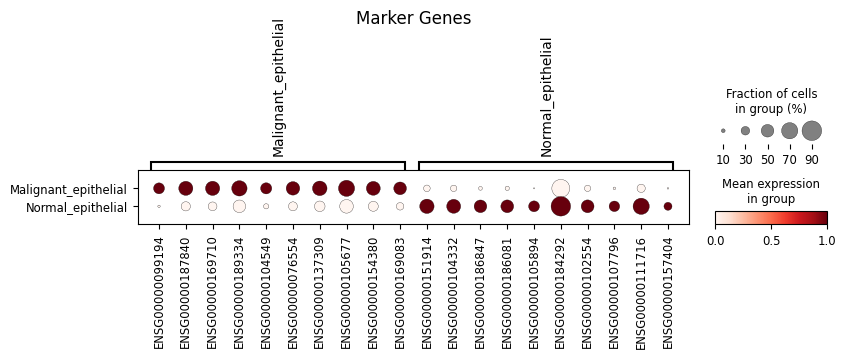

In [112]:
# DOTPLOT
# Crea il dotplot
sc.pl.rank_genes_groups_dotplot(
    a_filtered,
    groupby=group,
    standard_scale="var",
    n_genes=10,
    title="Marker Genes", 
    show=True,
    save=f"Marker_Genes_{b}.pdf")


In [113]:
cancer_genes = sc.get.rank_genes_groups_df(a_filtered, group="Malignant_epithelial")
output_path = f'results/cancer_genes_Malignant_epithelial_{b}.csv'
cancer_genes.to_csv(output_path, index=False)

In [114]:
# IDC_and_Normal_ILC

cancer_genes = pd.read_csv('results/cancer_genes_Malignant_epithelial_IDC_and_Normal_ILC.csv')

In [67]:
# IDC

cancer_genes = pd.read_csv('results/cancer_genes_Malignant_epithelial_IDC.csv') 

In [82]:
# IDC_and_ILC

cancer_genes = pd.read_csv('results/cancer_genes_Malignant_epithelial_IDC_ILC.csv') 

In [115]:
cancer_genes.sort_values('logfoldchanges')

,names,scores,logfoldchanges,pvals,pvals_adj
219,ENSG00000182916,-4.348114,-6.773314,1.373133e-05,3.527313e-05
275,ENSG00000105894,-41.003284,-6.489508,0.000000e+00,0.000000e+00
255,ENSG00000133392,-16.992723,-5.751114,9.297167e-65,5.916379e-64
250,ENSG00000137285,-13.192143,-5.509456,9.737616e-40,5.049134e-39
208,ENSG00000176692,-2.246025,-5.501187,2.470242e-02,5.048670e-02
...,...,...,...,...,...
110,ENSG00000177575,0.252866,3.942485,8.003717e-01,9.875694e-01
30,ENSG00000166803,9.565592,4.116506,1.115616e-21,4.462465e-21
117,ENSG00000262406,0.205918,4.617603,8.368551e-01,9.971039e-01
25,ENSG00000148773,11.163978,6.445093,6.119107e-29,2.677109e-28


In [116]:
cancer_genes_log = cancer_genes[(cancer_genes[variable] > 0.58) & (cancer_genes['pvals'] <= 0.01)]
normal_genes_log = cancer_genes[(cancer_genes[variable] < -0.58) & (cancer_genes['pvals'] <= 0.01)]

In [117]:
# Assegno il risultato con chiave dinamica
df_epit_selected_cancer = cancer_genes_log.sort_values(by=variable, ascending=False).head(n_genes)['names']
df_epit_selected_normal= normal_genes_log.sort_values(by=variable, ascending=True).head(n_genes)['names']

# Salva i nomi dei geni come file di testo (uno per riga)
#df_epit_selected_cancer.to_csv("cancer_genes.txt", index=False, header=False)
#df_epit_selected_normal.to_csv("normal_genes.txt", index=False, header=False)


In [118]:
# Score su epithelial_cells
sc.tl.score_genes(epithelial_cells, df_epit_selected_cancer, ctrl_as_ref=True, score_name='malignant_signature')
sc.tl.score_genes(epithelial_cells, df_epit_selected_normal, ctrl_as_ref=True, score_name='normal_signature')

In [87]:
#df_epit_selected_cancer_IDC_and_Normal_ILC = df_epit_selected_cancer
#df_epit_selected_cancer_IDC = df_epit_selected_cancer
df_epit_selected_cancer_IDC_ILC = df_epit_selected_cancer

#df_epit_selected_normal_IDC_and_Normal_ILC = df_epit_selected_normal
#df_epit_selected_normal_IDC = df_epit_selected_normal
#df_epit_selected_normal_IDC_ILC = df_epit_selected_normal

In [88]:
sig_idc = df_epit_selected_cancer_IDC
sig_idc_ilcN = df_epit_selected_cancer_IDC_and_Normal_ILC
sig_idc_ilc = df_epit_selected_cancer_IDC_ILC

In [89]:
import mygene
import pandas as pd

# Dizionario con i tuoi set di Ensembl IDs
signature_dict = {
    "IDC(N+T)": sig_idc,
    "IDC(N+T) + ILC(N)": sig_idc_ilcN,
    "IDC(N+T) + ILC(N+T)": sig_idc_ilc
}

# Inizializza mygene
mg = mygene.MyGeneInfo()

# Dizionario per salvare i DataFrame convertiti
converted_dfs = {}

for name, gene_list in signature_dict.items():
    # Rimuovi suffissi tipo ".1", ".2"
    cleaned_ids = [g.split('.')[0] for g in gene_list]

    # Query a MyGene
    results = mg.querymany(
        cleaned_ids,
        scopes='ensembl.gene',
        fields='symbol',
        species='human'
    )

    # Crea mappa Ensembl → Symbol
    id_to_symbol = {r['query']: r.get('symbol', 'NA') for r in results}

    # Lista simboli ordinata in base all’ordine originale
    gene_symbols = [id_to_symbol.get(g.split('.')[0], 'NA') for g in gene_list]

    # Salva come DataFrame separato
    df = pd.DataFrame({
        "ensembl_id": gene_list,
        "gene_symbol": gene_symbols
    })

    converted_dfs[name] = df

    # Stampa preview
    print(f"\n==== {name} ====")
    print(df.head())

# Ora puoi accedere ai DataFrame separati così:
#converted_dfs["IDC(N+T)"]
# converted_dfs["IDC(N+T) + ILC(N)"]
# converted_dfs["IDC(N+T) + ILC(N+T"]


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed



==== IDC(N+T) ====
         ensembl_id gene_symbol
29  ENSG00000148773       MKI67
0   ENSG00000099194         SCD
54  ENSG00000109424        UCP1
22  ENSG00000117724       CENPF
34  ENSG00000166803       PCLAF


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed



==== IDC(N+T) + ILC(N) ====
         ensembl_id gene_symbol
25  ENSG00000148773       MKI67
30  ENSG00000166803       PCLAF
0   ENSG00000099194         SCD
16  ENSG00000086548     CEACAM6
63  ENSG00000172236      TPSAB1

==== IDC(N+T) + ILC(N+T) ====
         ensembl_id gene_symbol
29  ENSG00000148773       MKI67
30  ENSG00000166803       PCLAF
0   ENSG00000099194         SCD
58  ENSG00000172236      TPSAB1
19  ENSG00000086548     CEACAM6


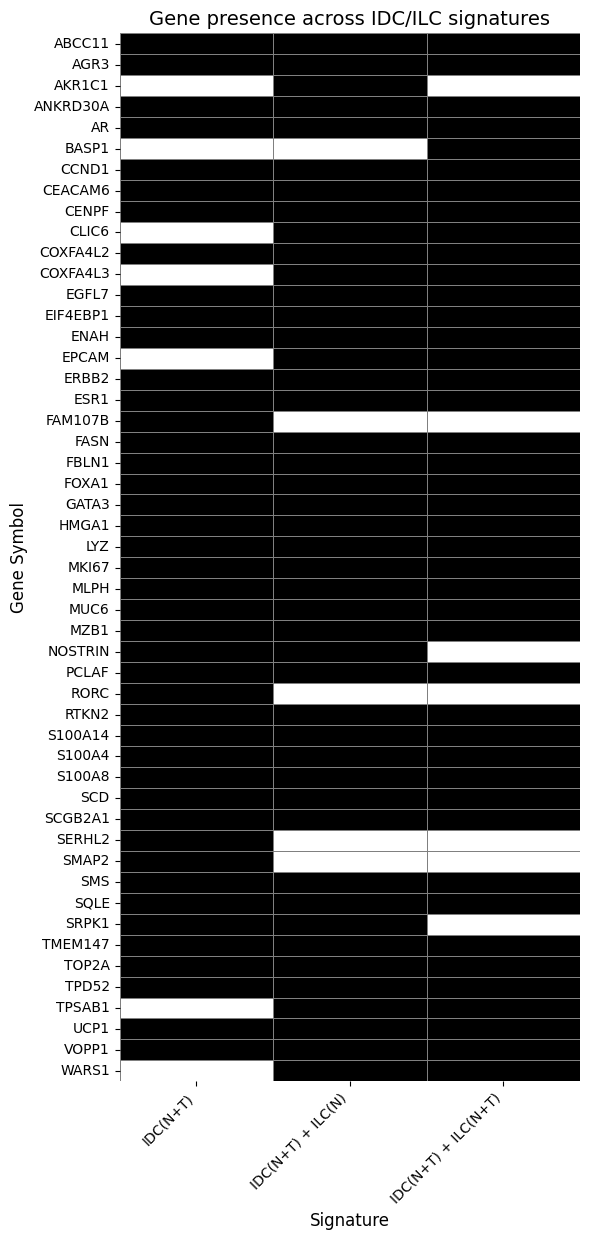

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Usa i DataFrame convertiti da prima (con colonne "gene_symbol")
# Esempio: converted_dfs["sig_idc"], ecc.

# Step 1: Crea un dizionario con insiemi di simboli genici
gene_sets_symbol = {
    name: set(df["gene_symbol"]) - {"NA", ""}  # rimuove simboli mancanti
    for name, df in converted_dfs.items()
}

# Step 2: Ottieni tutti i simboli genici unici
all_genes = sorted(set().union(*gene_sets_symbol.values()))

# Step 3: Crea la matrice binaria
data = {
    group: [1 if gene in gene_sets_symbol[group] else 0 for gene in all_genes]
    for group in gene_sets_symbol
}

df_binary = pd.DataFrame(data, index=all_genes)

# Step 4: Plot della heatmap binaria
bw_cmap = ListedColormap(["white", "black"])

plt.figure(figsize=(6, len(df_binary) * 0.25))
sns.heatmap(
    df_binary,
    cmap=bw_cmap,
    cbar=False,
    linewidths=0.5,
    linecolor='grey'
)

plt.title("Gene presence across IDC/ILC signatures", fontsize=14)
plt.xlabel("Signature", fontsize=12)
plt.ylabel("Gene Symbol", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("figures/gene_symbol_heatmap.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close()


In [91]:
signature_idc = set(sig_idc)  # idc (tumor+normal)
signature_idc_ilcN = set(sig_idc_ilcN)  # idc (tumor+normal) + ilc(normal)
signature_idc_ilc = set(sig_idc_ilc)  # idc (tumor+normal) + ilc(tumor+normal)

# Intersezione tra tutte e tre
intersection_all = signature_idc & signature_idc_ilcN & signature_idc_ilc

# Geni unici per ogni signature
unique_idc = signature_idc - (signature_idc_ilcN | signature_idc_ilc)
unique_idc_ilcN = signature_idc_ilcN - (signature_idc | signature_idc_ilc)
unique_idc_ilc = signature_idc_ilc - (signature_idc | signature_idc_ilcN)

# Geni condivisi solo tra alcune
shared_idc_ilcN = signature_idc & signature_idc_ilcN
shared_idc_ilc = signature_idc & signature_idc_ilc
shared_ilcN_ilc = signature_idc_ilcN & signature_idc_ilc

# Condivisi solo tra IDC e ILC(N), esclusi da ILC(T)
shared_only_idc_ilcN = (signature_idc & signature_idc_ilcN) - signature_idc_ilc
# Condivisi solo tra IDC e ILC, esclusi da ILC(N)
shared_only_idc_ilc = (signature_idc & signature_idc_ilc) - signature_idc_ilcN
# Condivisi solo tra ILC(N) e ILC, esclusi da IDC
shared_only_ilcN_ilc= (signature_idc_ilcN & signature_idc_ilc) - signature_idc

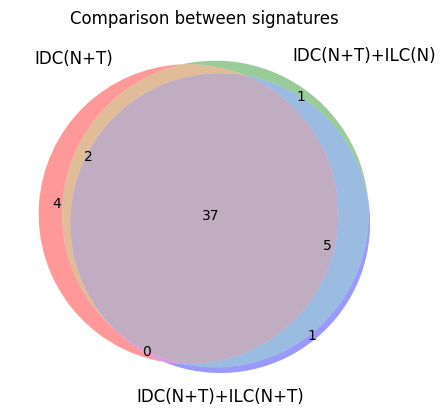

In [92]:
venn3([signature_idc, signature_idc_ilcN, signature_idc_ilc], 
      set_labels=('IDC(N+T)', 'IDC(N+T)+ILC(N)', 'IDC(N+T)+ILC(N+T)'))
plt.title("Comparison between signatures")
plt.savefig("figures/venn_signatures_comparison.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [93]:
gene_sets = {
    'IDC(N+T)': unique_idc,
    'IDC(N+T) + ILC(N)': unique_idc_ilcN,
    'IDC(N+T) + ILC(N+T)': unique_idc_ilc,
    'Shared all': intersection_all,
    'Shared only IDC e IDC + ILC(N)': shared_only_idc_ilcN,
    'Shared only IDC e IDC + ILC': shared_only_idc_ilc,
    'Shared only ILC(N) e ILC': shared_only_ilcN_ilc
}

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
18 input query terms found dup hits:	[('ENSG00000188660', 2), ('ENSG00000226506', 2), ('ENSG00000226519', 2), ('ENSG00000227110', 2), ('E
602 input query terms found no hit:	['ENSG00000131484', 'ENSG00000132832', 'ENSG00000139656', 'ENSG00000146521', 'ENSG00000168078', 'ENS


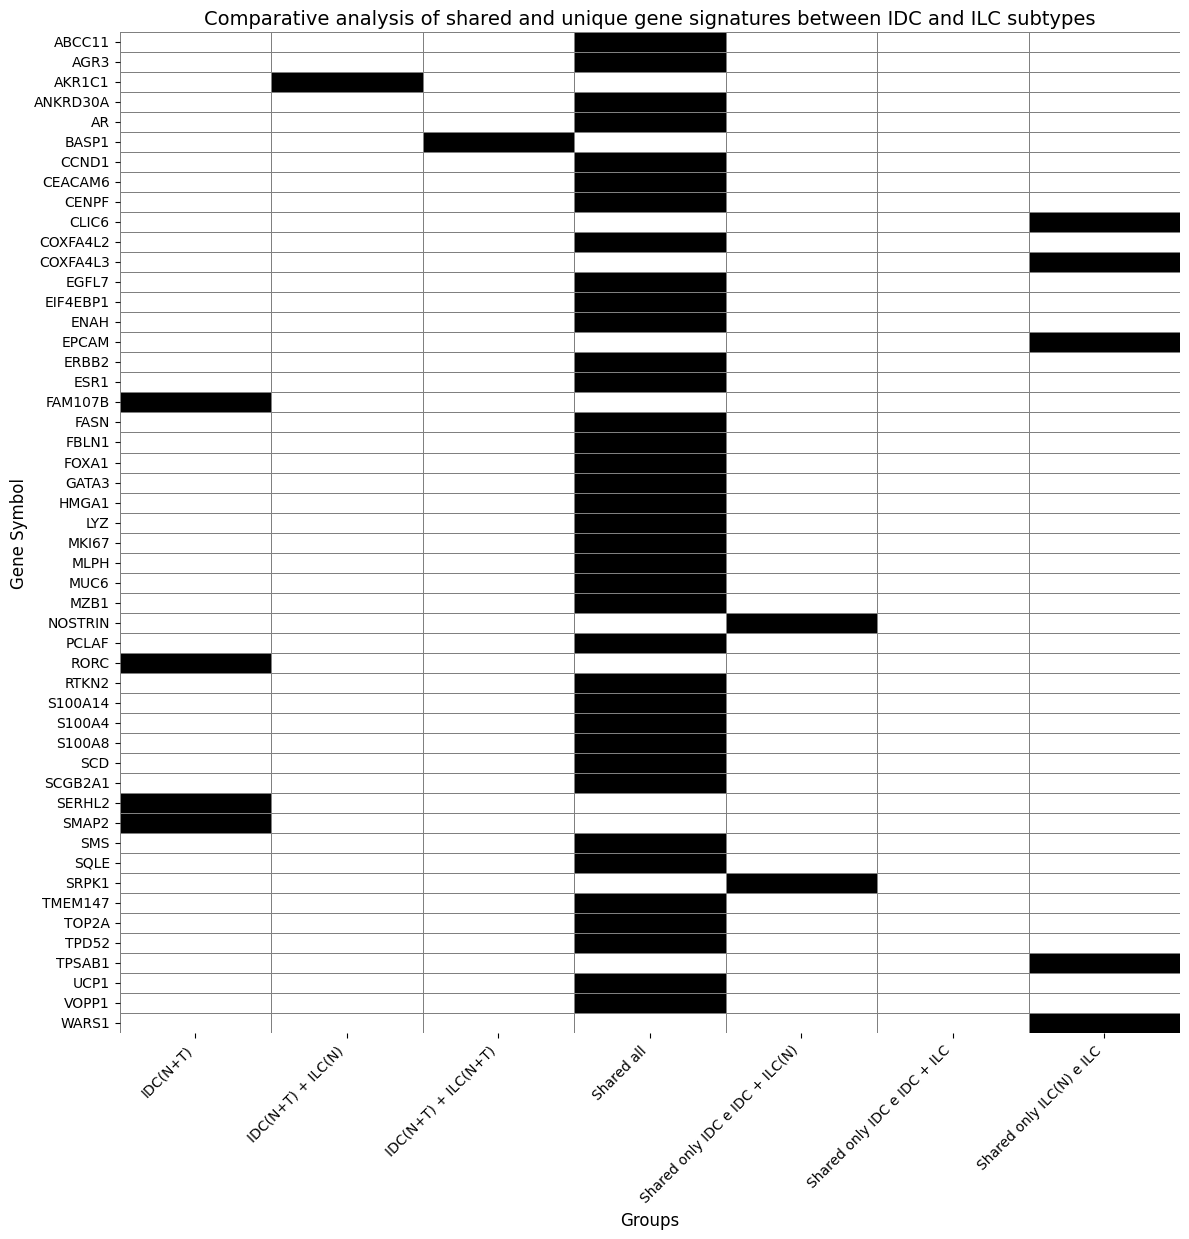

In [94]:
# --- Step 1: Converti Ensembl IDs in gene symbol con mygene ---
import mygene

# Inizializza mygene
mg = mygene.MyGeneInfo()

# Rimuovi eventuali suffissi (.1, .2, ...) dagli Ensembl ID
ensembl_ids = [gene.split('.')[0] for gene in adata.var.index]

# Interroga mygene per ottenere i simboli
result = mg.querymany(
    ensembl_ids,
    scopes='ensembl.gene',
    fields='symbol',
    species='human'
)

# Costruisci il dizionario Ensembl → Symbol
id_to_symbol = {r['query']: r.get('symbol', '') for r in result if not r.get('notfound', False)}

# Aggiungi la nuova colonna in adata.var
adata.var['gene_symbol'] = [id_to_symbol.get(gene.split('.')[0], '') for gene in adata.var.index]

# --- Step 2: Converti gene_sets da Ensembl a Symbol ---
# Supponendo che gene_sets contenga insiemi di Ensembl ID:
# Esempio:
# gene_sets = {
#     'Only IDC': unique_idc,
#     ...
# }

gene_sets_symbol = {
    group: {id_to_symbol.get(gene.split('.')[0], '') for gene in genes}
    for group, genes in gene_sets.items()
}

# Rimuovi eventuali simboli vuoti ('') se presenti
gene_sets_symbol = {
    group: {gene for gene in genes if gene} for group, genes in gene_sets_symbol.items()
}

# --- Step 3: Crea matrice binaria ---
import pandas as pd

all_genes = sorted(set().union(*gene_sets_symbol.values()))
all_groups = gene_sets_symbol.keys()

data = {
    group: [1 if gene in gene_sets_symbol[group] else 0 for gene in all_genes]
    for group in all_groups
}

df_binary = pd.DataFrame(data, index=all_genes)

# --- Step 4: Plot della heatmap binaria con simboli genici ---
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

# Colormap: bianco = 0, nero = 1
bw_cmap = ListedColormap(["white", "black"])

plt.figure(figsize=(12, len(all_genes) * 0.25))
sns.heatmap(
    df_binary,
    cmap=bw_cmap,
    cbar=False,
    linewidths=0.5,
    linecolor='grey'
)

plt.title("Comparative analysis of shared and unique gene signatures between IDC and ILC subtypes", fontsize=14)
plt.xlabel("Groups", fontsize=12)
plt.ylabel("Gene Symbol", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("figures/gene_signature_analysis.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close()


In [95]:
venn3(
    [gene_sets_symbol['Only IDC'], 
     gene_sets_symbol['Only IDC + ILC(N)'], 
     gene_sets_symbol['Only IDC + ILC']],
    set_labels=('IDC', 'IDC+ILC(N)', 'IDC+ILC')
)
plt.title("Venn Diagram of Gene Signatures")
plt.savefig("figures/venn_diagram_of_gene_signatures.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

KeyError: 'Only IDC'

In [59]:
# Conta delle cellule epiteliali maligne
n_malignant = a.obs[a.obs['celltype_major'] == 'Malignant_epithelial'].shape[0]

# Conta delle cellule epiteliali normali
n_normal = a.obs[a.obs['celltype_major'] == 'Normal_epithelial'].shape[0]

print(f"Malignant epithelial cells: {n_malignant}")
print(f"Normal epithelial cells: {n_normal}")


Malignant epithelial cells: 19829
Normal epithelial cells: 4355


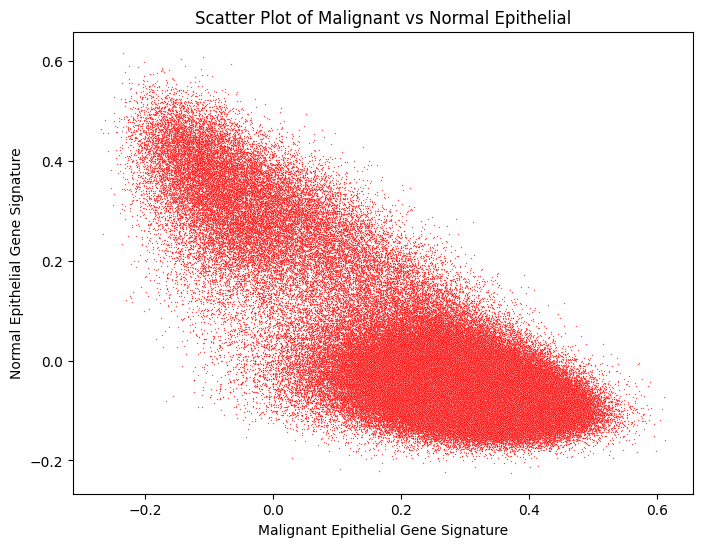

In [378]:
# SCATTERPLOT
x = epithelial_cells.obs['malignant_signature']
y = epithelial_cells.obs['normal_signature']

plt.figure(figsize=(8, 6))

sns.scatterplot(x=x, y=y, color='red', alpha=0.7, s=1)

plt.xlabel('Malignant Epithelial Gene Signature')
plt.ylabel('Normal Epithelial Gene Signature')
plt.title('Scatter Plot of Malignant vs Normal Epithelial')
plt.savefig(f"figures/SCATTER_malignant_vs_normal_{b}.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

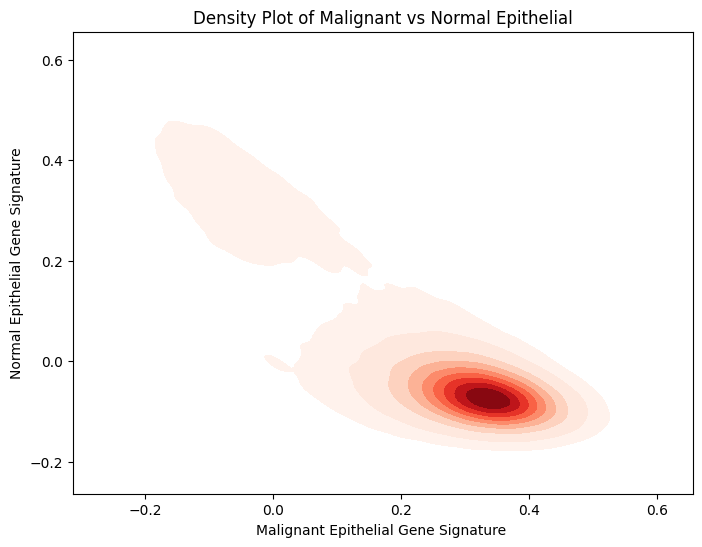

In [367]:
# DENSITY PLOT
x = epithelial_cells.obs['malignant_signature']
y = epithelial_cells.obs['normal_signature']

plt.figure(figsize=(8, 6))

sns.kdeplot(x=x, y=y, cmap="Reds", fill=True, thresh=0.05)

plt.xlabel('Malignant Epithelial Gene Signature ')
plt.ylabel('Normal Epithelial Gene Signature')
plt.title('Density Plot of Malignant vs Normal Epithelial')
plt.savefig(f"figures/DENSITY_malignant_vs_normal_{b}.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close() 

Cell type counts:
 cell_type_prediction
Malignant    319360
Normal        25274
Unknown        4348
Name: count, dtype: int64


/tmp/ipykernel_2203727/2539767840.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


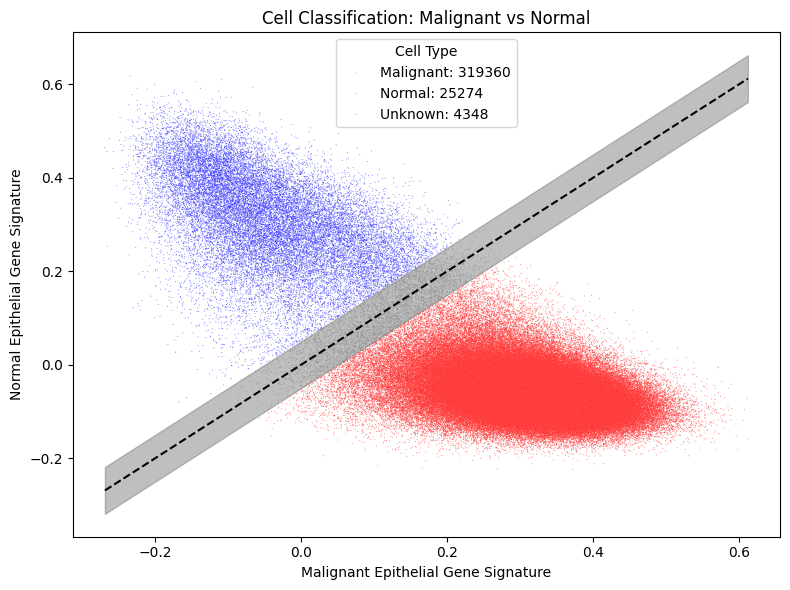

/tmp/ipykernel_2203727/2539767840.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=cell_counts.index, y=cell_counts.values, palette=['red', 'blue', 'gray'])


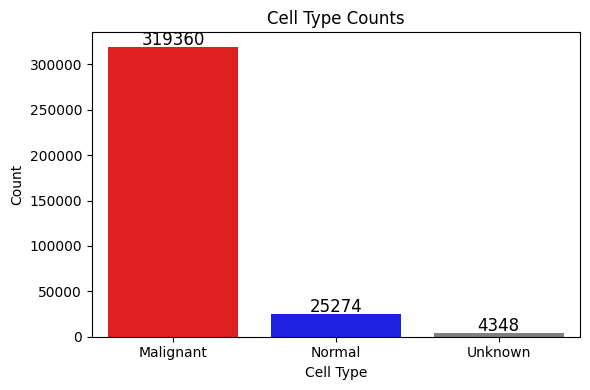

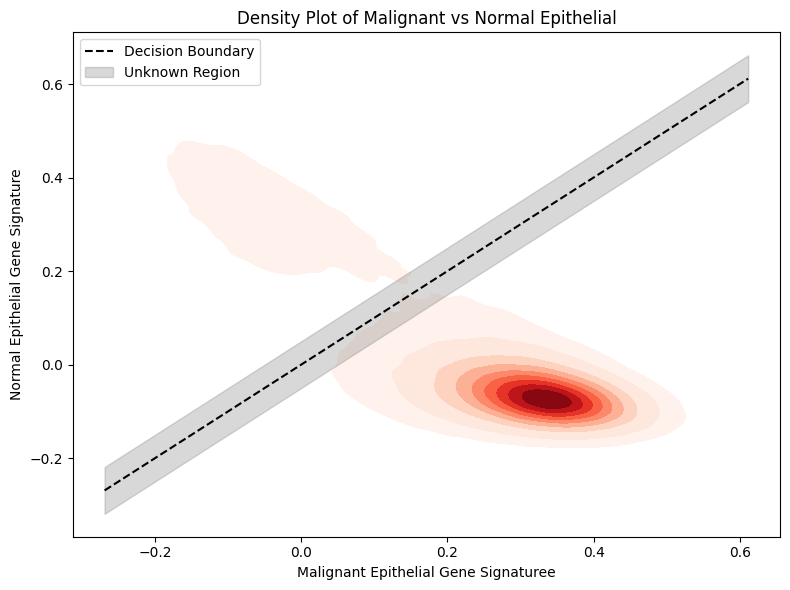

In [119]:
x = epithelial_cells.obs['malignant_signature']
y = epithelial_cells.obs['normal_signature']

# Parametro: larghezza della fascia "unknown"
boundary_width = 0.05

diff = y - x

def classify(diff_value, threshold):
    if diff_value > threshold:
        return 'Normal'
    elif diff_value < -threshold:
        return 'Malignant'
    else:
        return 'Unknown'

epithelial_cells.obs['cell_type_prediction'] = diff.apply(lambda d: classify(d, threshold=boundary_width))

# Conto le cellule per categoria
cell_counts = epithelial_cells.obs['cell_type_prediction'].value_counts()
print("Cell type counts:\n", cell_counts)

# --- SCATTERPLOT CON DIAGONALE E BOUNDARY "UNKNOWN" ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=x,
    y=y,
    hue=epithelial_cells.obs['cell_type_prediction'],
    hue_order=['Malignant', 'Normal', 'Unknown'], 
    palette={'Malignant': 'red', 'Normal': 'blue', 'Unknown': 'gray'},
    alpha=0.6,
    s=0.5)

plt.plot([x.min(), x.max()], [x.min(), x.max()], color='black', linestyle='--', label='Decision Boundary')
x_vals = np.linspace(x.min(), x.max(), 500)
plt.fill_between(x_vals, x_vals - boundary_width, x_vals + boundary_width, 
                 color='gray', alpha=0.5, label='Unknown Region')
plt.xlabel('Malignant Epithelial Gene Signature')
plt.ylabel('Normal Epithelial Gene Signature')
plt.title('Cell Classification: Malignant vs Normal')
plt.legend(title="Cell Type", labels=[
    f"Malignant: {cell_counts.get('Malignant', 0)}", 
    f"Normal: {cell_counts.get('Normal', 0)}", 
    f"Unknown: {cell_counts.get('Unknown', 0)}"
])
plt.tight_layout()
plt.savefig("figures/scatter_malignant_vs_normal.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# --- BARPLOT CONTEGGIO CELLULE ---
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=cell_counts.index, y=cell_counts.values, palette=['red', 'blue', 'gray'])
plt.title('Cell Type Counts')
plt.xlabel('Cell Type')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')
plt.tight_layout()
plt.savefig("figures/barplot_cell_counts.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# --- DENSITY PLOT ---
plt.figure(figsize=(8, 6))
sns.kdeplot(x=x, y=y, cmap="Reds", fill=True, thresh=0.05)
plt.plot([x.min(), x.max()], [x.min(), x.max()], color='black', linestyle='--', label='Decision Boundary')
plt.fill_between(x_vals, x_vals - boundary_width, x_vals + boundary_width, 
                 color='gray', alpha=0.3, label='Unknown Region')
plt.xlabel('Malignant Epithelial Gene Signaturee')
plt.ylabel('Normal Epithelial Gene Signature')
plt.title('Density Plot of Malignant vs Normal Epithelial')
plt.legend()
plt.tight_layout()
plt.savefig("figures/density_malignant_vs_normal.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [120]:
# cARICO l'anndata iniziale dove ho salvato solo le cellule epitheliali e la classificazione in level1 e level2
epithelial_cells_old = sc.read_h5ad("epithelial_cells_level2.h5ad")

In [121]:
# Aggiungo al file iniziale la colonna cell_type_prediction trovate (in questo modo i gene_symbol rimangono intatti
# Copia le colonne da epithelial_cells a epithelial_cells_old
epithelial_cells_old.obs['malignant_signature'] = epithelial_cells.obs['malignant_signature']
epithelial_cells_old.obs['normal_signature'] = epithelial_cells.obs['normal_signature']
epithelial_cells_old.obs['cell_type_prediction'] = epithelial_cells.obs['cell_type_prediction']

In [122]:
# SALVO IL FILE epithelial_cells il quale è un andata che contiene solo le cellule epiteliali di xenium 
# con la classificazione in level1 e level2 fatta da Marco e con la classificazione predetta da me

# # Rimuovi il nome dell'indice (senza modificare i dati): poichè sia l'indice che la prima colonna si chiamavano cell_id e creava un conflitto
#epithelial_cells.obs.index.name = None

# Salvo il file
epithelial_cells_old.write("epithelial_cells_cell_type_prediction.h5ad")

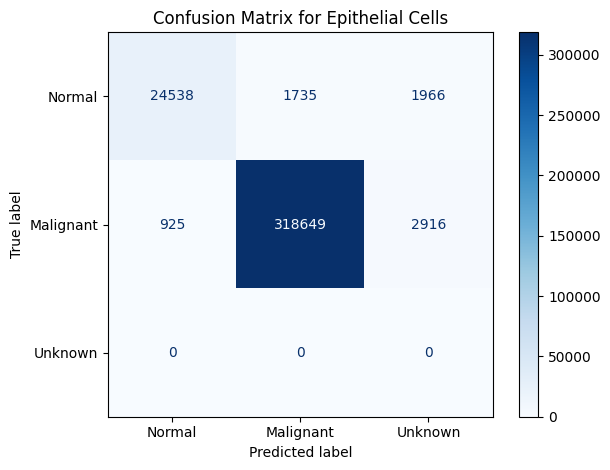

Classification Report for Epithelial Cells (Normal/Malignant only):
              precision    recall  f1-score   support

      Normal       0.96      0.87      0.91     28239
   Malignant       0.99      0.99      0.99    322490

   micro avg       0.99      0.98      0.99    350729
   macro avg       0.98      0.93      0.95    350729
weighted avg       0.99      0.98      0.99    350729



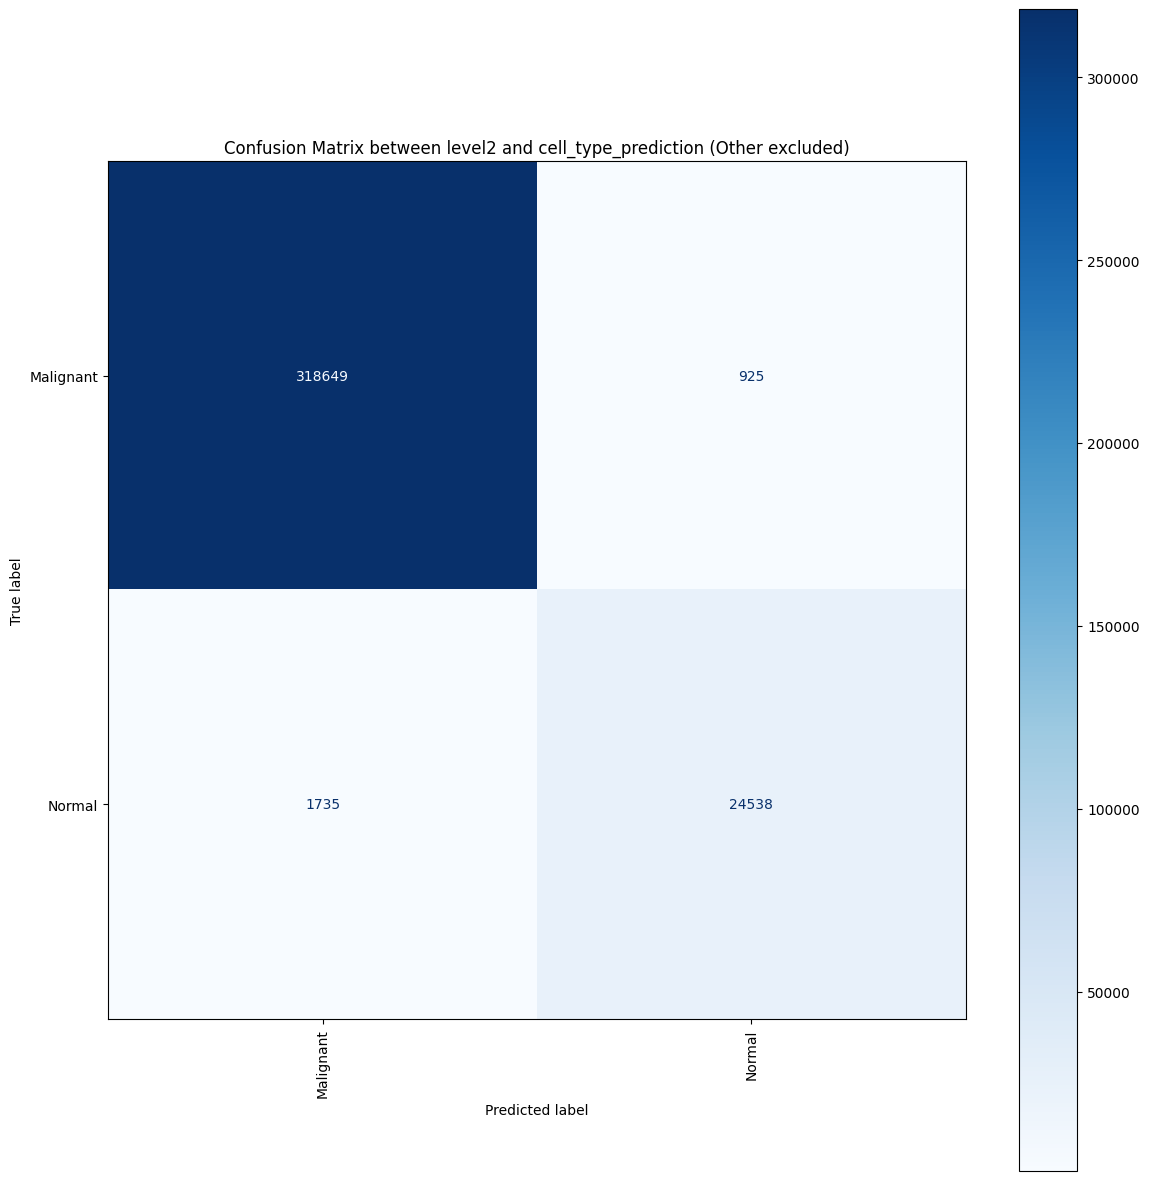

In [131]:
def plot_and_save_confusion_matrix(y_true, y_pred, labels, display_labels, title, filename, figsize=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    
    if figsize:
        fig, ax = plt.subplots(figsize=figsize)
        disp.plot(ax=ax, cmap='Blues', values_format='d', xticks_rotation='vertical')
    else:
        disp.plot(cmap='Blues', values_format='d')
    
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

# Primo plot: epithelial cells
epithelial_true = epithelial_cells.obs['level2']
epithelial_pred = epithelial_cells.obs['cell_type_prediction']
labels = ["Normal", "Malignant", "Unknown"]

plot_and_save_confusion_matrix(
    y_true=epithelial_true,
    y_pred=epithelial_pred,
    labels=labels,
    display_labels=labels,
    title="Confusion Matrix for Epithelial Cells",
    filename="figures/confusion_matrix.pdf")

# Report di classificazione (solo Normal e Malignant)
print("Classification Report for Epithelial Cells (Normal/Malignant only):")
print(classification_report(
    epithelial_true,
    epithelial_pred,
    labels=["Normal", "Malignant"],
    target_names=["Normal", "Malignant"]))

# Secondo plot: filtered cells (senza "Other")
obs_filtered = obs[obs["cell_type_prediction"] != "Other"]
labels_filtered = sorted(obs_filtered['level2'].unique())

plot_and_save_confusion_matrix(
    y_true=obs_filtered['level2'],
    y_pred=obs_filtered['cell_type_prediction'],
    labels=labels_filtered,
    display_labels=labels_filtered,
    title='Confusion Matrix between level2 and cell_type_prediction (Other excluded)',
    filename="figures/confusion_matrix_filtered.pdf",
    figsize=(12, 12))

In [391]:
metadata = epithelial_cells.obs[['level1', 'level2', 'cell_type_prediction']]

# Identifico gli indici di 'xenium.table.obs' che non sono in epithelial_cells.obs
missing_indices = set(xenium.table.obs.index) - set(epithelial_cells.obs.index)

# Creo un DataFrame con le celle mancanti, assegnando 'other' come valore per i metadati
missing_metadata = pd.DataFrame(
    index=list(missing_indices),
    data={"level1": "Other", "level2": "Other", "cell_type_prediction": "Other"})

# Seleziono i metadati solo per le cellule presenti in epithelial_cells
existing_metadata = metadata.loc[metadata.index.intersection(xenium.table.obs.index)]

# Combino i dati esistenti con quelli delle cellule mancanti
full_metadata = pd.concat([existing_metadata, missing_metadata]).reindex(xenium.table.obs.index)

# Aggiungo le colonne aggiornate a xenium.table.obs
xenium.table.obs[['level1', 'level2', 'cell_type_prediction']] = full_metadata[['level1', 'level2', 'cell_type_prediction']]

print(xenium.table.obs.head())

   cell_id  transcript_counts  control_probe_counts  control_codeword_counts  \
0        1                 73                     0                        0   
1        2                 43                     0                        0   
2        3                 56                     0                        0   
3        4                 61                     0                        0   
4        5                130                     0                        0   

   total_counts   cell_area  nucleus_area        region  \
0            73  151.408906     26.597031  cell_circles   
1            43   70.127656      9.257031  cell_circles   
2            56   56.355000     10.792344  cell_circles   
3            61  132.036875     15.262813  cell_circles   
4           130  138.765156     19.733281  cell_circles   

                            sample level1 level2 cell_type_prediction  
0  Xenium_V1_FFPE_Human_Breast_IDC  Other  Other                Other  
1  Xenium_V1_FFPE_Hu

In [392]:
xenium.tables['table'].uns['spatialdata_attrs']['region'] = 'nucleus_boundaries'
xenium.tables['table'].obs['region']='nucleus_boundaries'

In [ ]:
# Configurazione generale
warnings.filterwarnings('ignore')  # Disabilita tutti i warning

# Funzione per generare i plot spaziali (SENZA TITOLO)
def generate_spatial_plot(sdata, element, color_var):
    """Genera un plot spaziale con le specifiche date"""
    # Converti a categorical se necessario
    if color_var in sdata.tables['table'].obs:
        sdata.tables['table'].obs[color_var] = sdata.tables['table'].obs[color_var].astype('category')
    
    # Genera il plot
    sdata.pl.render_shapes(
        element=element,
        color=color_var,
        table_name='table',
        method='matplotlib'    ).pl.show()

# Funzione per generare il barplot delle celle discordanti (CON TITOLO)
def generate_mismatch_barplot(mismatched_data):
    """Genera un barplot delle celle discordanti"""
    # Conto le cellule per tipo
    cell_counts = mismatched_data.tables['table'].obs['cell_type_prediction'].value_counts().sort_values(ascending=False)

    print("\nConteggio cellule discordanti per tipo:")
    print(cell_counts)

    # BARPLOT
    plt.figure(figsize=(10,6))
    ax = sns.barplot(
        x=cell_counts.index, 
        y=cell_counts.values, 
        palette="viridis",
        order=cell_counts.index)
    
    # Aggiungo le etichette numeriche sopra le barre
    for i, count in enumerate(cell_counts.values):
        ax.text(
            i, 
            count + 0.5,
            str(count), 
            ha='center', 
            va='bottom', 
            fontweight='bold')
        
    plt.title(f"Distribution of Discordant Cells (n={sum(cell_counts.values)})", pad=20)  
    plt.xlabel("Predicted Cell Type", labelpad=10)  
    plt.ylabel("Number of Cells", labelpad=10)  
    plt.xticks(rotation=45, ha='right')
    plt.margins(y=0.1)
    plt.tight_layout()
    plt.show()

# 1. Plot CLASSIFICAZIONE PREDETTA (cell_type_prediction)
generate_spatial_plot(
    sdata=xenium,
    element='nucleus_boundaries',
    color_var='cell_type_prediction')

# 2. Plot CLASSIFICAZIONE INIZIALE (level2)
generate_spatial_plot(
    sdata=xenium,
    element='nucleus_boundaries',
    color_var='level2',
    )

# 3. Plot CELLE DISCORDANTI (mismatch)
# Identifica le celle discordanti
obs = xenium.tables['table'].obs.copy()
mismatched_mask = (
    (obs['cell_type_prediction'] != 'Other') & 
    (obs['cell_type_prediction'].astype(str) != obs['level2'].astype(str)))
mismatched_indices = obs.index[mismatched_mask]

# Stampa il numero di celle discordanti
num_mismatched = len(mismatched_indices)
print(f"\nNumber of mismatched cells between classifications: {num_mismatched}")

# Crea subset per le celle discordanti e genera i plot
if num_mismatched > 0:
    mismatched_data = SpatialData(
        tables={'table': xenium.tables['table'][mismatched_indices]},
        shapes={'nucleus_boundaries': xenium.shapes['nucleus_boundaries']})
    
    # Plot spaziale delle celle discordanti (SENZA TITOLO)
    generate_spatial_plot(
        sdata=mismatched_data,
        element='nucleus_boundaries',
        color_var='cell_type_prediction')
    
    # Barplot delle celle discordanti (CON TITOLO)
    generate_mismatch_barplot(mismatched_data)
else:
    print("No mismatched cells found between classifications")

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_circles` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                
INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/tmp/ipykernel_108879/3862943443.py:4: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  clic6_expr = xenium.table[:, "CLIC6"].X


Number of cells with CLIC6 expressed: 409337


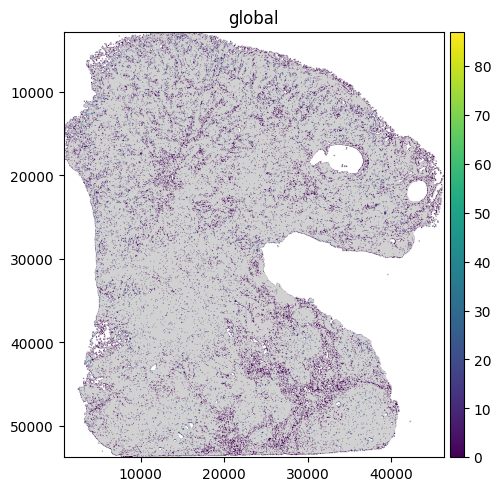

In [84]:
xenium.pl.render_shapes(color="CLIC6").pl.show()

# Trovo le cellule in cui il gene CLIC6 è espresso
clic6_expr = xenium.table[:, "CLIC6"].X

# Conto quante cellule hanno un'espressione > 0
n_total_cells = np.array(clic6_expr > 0).sum()
print(f"Number of cells with CLIC6 expressed: {clic6_expr.nnz}")

Number of 'Unknown' cells expressing CLIC6: 3138
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_circles` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


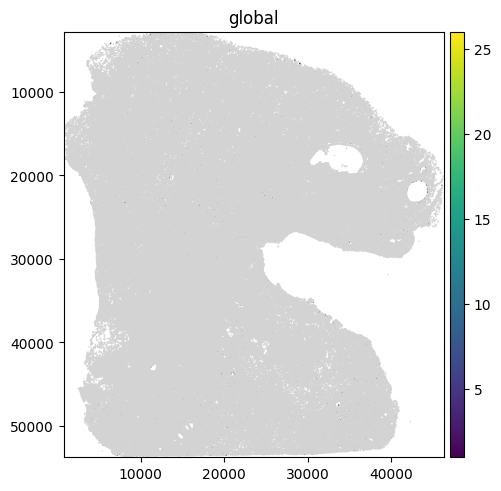

In [103]:
# Filtro le cellule 'Unknown'
unknown_mask = epithelial_cells_old.obs['cell_type_prediction'] == 'Unknown'
unknown_cells = epithelial_cells_old[unknown_mask, :]

# Estrai l'espressione del gene 'CLIC6' come array denso
clic6_expr_unknown = unknown_cells[:, "CLIC6"].X

# Converti in array NumPy (gestendo il caso sparso)
clic6_array = clic6_expr_unknown.toarray().flatten() if hasattr(clic6_expr_unknown, "toarray") else np.array(clic6_expr_unknown).flatten()

# Mask: espressione > 0
expressed_mask = clic6_array > 0

# Ottieni gli ID delle celle 'Unknown' che esprimono CLIC6
expressed_cell_ids = unknown_cells.obs_names[expressed_mask]

# Sottoset: solo le 'Unknown' che esprimono CLIC6
expressed_cells = unknown_cells[expressed_cell_ids, :]

# Conta quante sono
print(f"Number of 'Unknown' cells expressing CLIC6: {expressed_cells.n_obs}")

# Crea SpatialData SOLO con queste cellule
sd_expressed = SpatialData(
    tables={'table': expressed_cells},
    shapes=xenium.shapes,
    images=xenium.images
)

# Plot solo delle cellule Unknown che esprimono CLIC6
sd_expressed.pl.render_shapes(color="CLIC6").pl.show()

Number of 'Unknown' cells expressing CXCL12: 1391
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                
INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


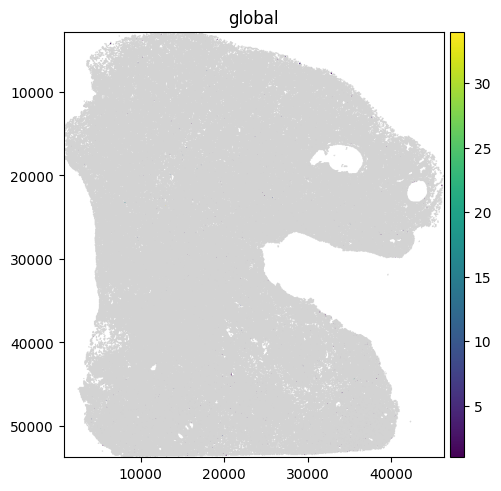

In [144]:
# Filtro le cellule 'Unknown'
unknown_mask = epithelial_cells_old.obs['cell_type_prediction'] == 'Unknown'
unknown_cells = epithelial_cells_old[unknown_mask, :]

# Estrai l'espressione del gene 'CLIC6' come array denso
clic6_expr_unknown = unknown_cells[:, "CXCL12"].X

# Converti in array NumPy (gestendo il caso sparso)
clic6_array = clic6_expr_unknown.toarray().flatten() if hasattr(clic6_expr_unknown, "toarray") else np.array(clic6_expr_unknown).flatten()

# Mask: espressione > 0
expressed_mask = clic6_array > 0

# Ottieni gli ID delle celle 'Unknown' che esprimono CLIC6
expressed_cell_ids = unknown_cells.obs_names[expressed_mask]

# Sottoset: solo le 'Unknown' che esprimono CLIC6
expressed_cells = unknown_cells[expressed_cell_ids, :]

# Conta quante sono
print(f"Number of 'Unknown' cells expressing CXCL12: {expressed_cells.n_obs}")

# Crea SpatialData SOLO con queste cellule
sd_expressed = SpatialData(
    tables={'table': expressed_cells},
    shapes=xenium.shapes,
    images=xenium.images
)

# Plot solo delle cellule Unknown che esprimono CLIC6
sd_expressed.pl.render_shapes(color="CXCL12").pl.show()